<a href="https://colab.research.google.com/github/Lupama2/IntroCUDA/blob/main/GoogleColab/ICNPG_ejercicio_permutacionimagen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubik-QR

Se le entregará una imagen encriptada cuadrada en formato pgm, de `N = L × L` pixels, que se puede visualizar fácilmente. La imagen se carga como un vector de host “`h_enc`”, tal que

```
h_enc [n = i + jL] ≡ ImagenEncriptada(i,j)
```

donde `i = 0, ..., L − 1` es la columna (eje horizontal o “X”), y 
`j = 0, ..., L − 1` la fila (eje vertical o “Y”) del pixel n. 

La imagen está encriptada de esta forma (ver Figura de abajo):

```
ImagenEncriptada(i′,j′) = ImagenOriginal(i,j)
i′ = (i + offsets[j]) %L
j′ = j
```

y donde los `offsets[j]` son la suma de todas las columnas (valores de pixel) de cada fila j, es
decir:

```
offsets[j] = ImagenOriginal(0, j)+ImagenOriginal(0, j)+...+ImagenOriginal(L-1, j)
```

## Su misión:
* Complete el template desencriptador.cu que desencripta en gpu y escribe la imagen desencriptada “h_des” en formato pgm. Si lo hizo bien, debería visualizar en el pgm de salida un código QR decente. 

* Escanee el código con su celular si tiene una aplicación QR-reader o bien cargue online la imagen desencriptada en [http://lector-codigos-qr.onlinegratis.tv/qr-reader/] (o en cualquier otro QR reader online que conozca) y vaya al link correspondiente. 

* La respuesta del ejericio la encontrará en la página web a donde es redirigido. ¡Comuníquesela a los docentes!





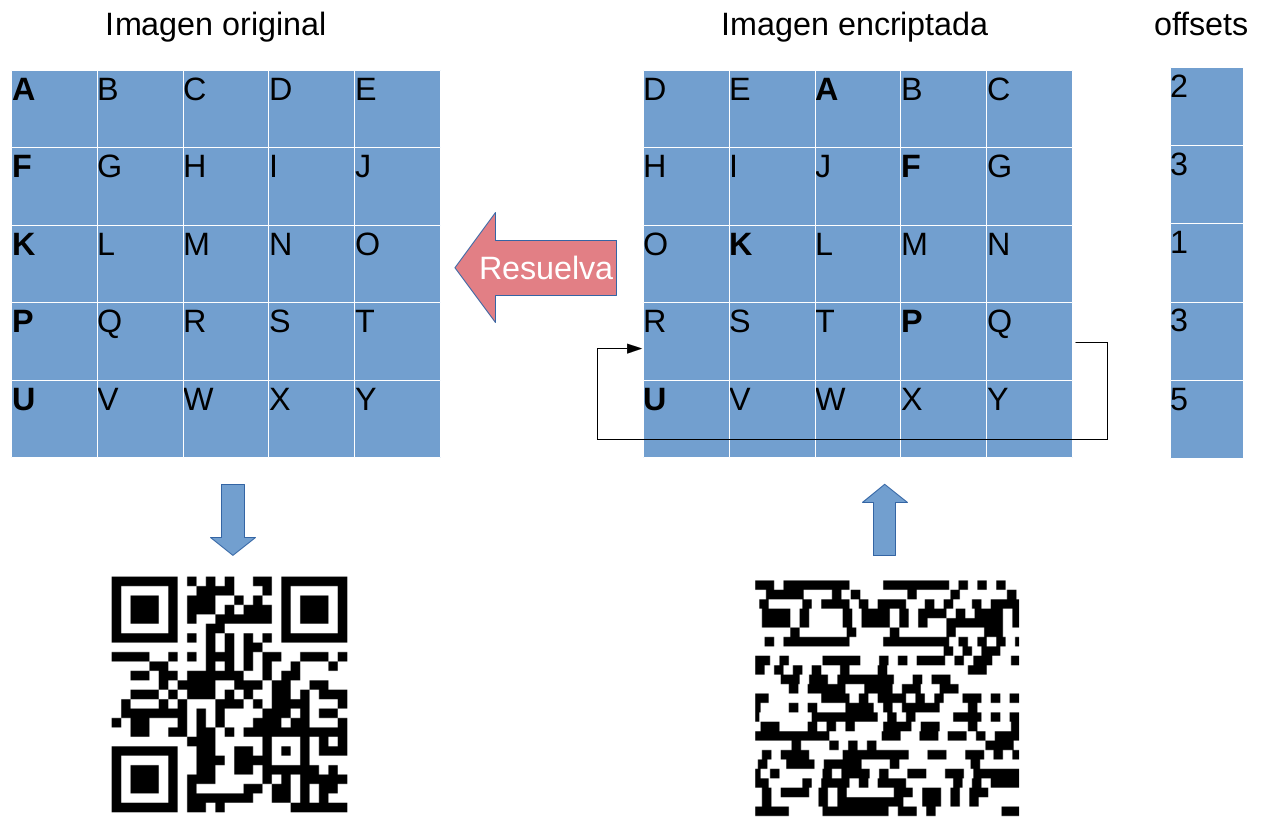

## Template del Código a completar

Las siguientes funciones sirven para leer/escribir una imagen en formato [pgm](https://netpbm.sourceforge.net/doc/pgm.html). Ejecutar asi las tenemos disponibles. 

In [ ]:
%%writefile desencript.h

// lee de pgm de un archivo y lo guarda en un thrust::host_vector
void leepgm(std::ifstream &finp, thrust::host_vector<int> &hz)
{
	// avanzamos sobre el encabezado de pgm
	std::string nombre;
	std::string doscincocinco("255");
	do{
		std::getline(finp,nombre);
	}while(nombre.compare(doscincocinco)!=0);

	int value;
	for(int i=0;i<L*L;i++)
	{
		finp >> value;
		hz[i]=value;
	}
}

// lee un thrust::host vector y lo guarda en un archivo pgm
void escribepgm(std::ofstream &fout, thrust::host_vector<int> &hz)
{
	fout << "P2\n" << L << " " << L << "\n255\n";
	for(int j=0;j<L*L;j++)
	{
		fout << hz[j] << std::endl;
	}
}


Overwriting desencript.h


# *Este es el único código que necesita modificar en el notebook para llegar a la respuesta.*

**Completar** lel siguiente código donde se indica con TODO. No modificar el resto. Se puede compilar sin completar para entender el proceso completo. Hágalo.

In [ ]:
%%writefile desencriptador.cu

#include<fstream>
#include<iostream>
#include<ctime>
#include<thrust/host_vector.h>
#include<thrust/device_vector.h>
// TODO: agregue los headers que considere necesario...
// ....

// vamos a fijar el tamanio de las imagenes a 200x200 pixeles
#define L	200

// declaracion/definicion de funciones de lectura/escritura
#include "desencript.h"

// TODO: escriba su/sus functors o su/sus kernels aqui abajo...
// ....


__global__
void kernel_offsets(int *offsets_raw, int *enc, int N){
	// Calculo los offsets con un kernel
	// offsets[j] = sum_i_0^(L-1) {h_des[i, j]}
	// offsets[j] = sum_i_0^(L-1) {h_enc[i', j']}
	// offsets[j] = sum_i'_(offsets[j]%L)^((L-1 + offsets[j])%L) {h_enc[i', j]}
	// offsets[j] = sum_i'_(offsets[j]%L)^((L-1 + offsets[j])%L) {h_enc[i', j]}
	// La suma es cíclica de modo que se está sumando desde el caso i' = 0, hasta el i' = L-1
	// offsets[j] = sum_i'_(0)^(L-1) {h_enc[i', j]}
	// offsets[j] = sum_i_(0)^(L-1) {h_enc[i, j]}
	// offsets[j] = sum_i_(0)^(L-1) {h_enc[i + j*L]}
	int j = blockIdx.x * blockDim.x + threadIdx.x;
	if (j < N){
		int offset = 0;

		for (int i = 0; i < L; i++){
			offset += enc[i + j*L];
		}
		offsets_raw[j] = offset;
}

__global__
void kernel_desencript(int *h_des, int *h_enc, int *offsets, int N){
	// Calculo h_des[i,j] con un kernel
	// i' = (i + offsets[j])%L
	// j' = j
	// h_des[i,j] = h_enc[i',j']
	int j = blockIdx.x * blockDim.x + threadIdx.x;
	if (j < N){
		for (int i = 0; i < L; i++){
			h_des[i + j*L] = h_enc[(i + offsets[j])%L + j*L];
		}
	}
	
}






// TODO: complete la siguiente funcion de desencriptacion
void desencriptar(char *name)
{	
	// numero total de pixels 
	int N=L*L;

        // declaramos vectores para la imagen encriptada, y para la desencriptada en el host de N=L*L pixels
	thrust::host_vector<int> h_enc(N); // imagen encriptada en host
	thrust::host_vector<int> h_des(N); // imagen desencriptada en host

	// lee la imagen encriptada en h_enc
	std::ifstream fin(name);	   // archivo de entrada
	leepgm(fin,h_enc);		   // lectura de imagen encriptada

        // Declaramos y alocamos vectores de device (de C o thrust) para la imagen encriptada y para la desencriptada
        // y hacemos la copia de la imagen encriptada de host a dev|ice
	thrust::device_vector<int> enc(h_enc);  
	thrust::device_vector<int> des(h_enc); 
	int *enc_raw=thrust::raw_pointer_cast(enc.data());
	int *des_raw=thrust::raw_pointer_cast(des.data());

        // TODO: declare y aloque vectores de device (thrust o C) para los offsets
	thrust::device_vector<int> offsets(N); // offsets de cada fila en device
	int *offsets_raw=thrust::raw_pointer_cast(offsets.data());

	// TODO: encuentre los offsets de cada fila en device
	kernel_offsets<<<(N+255)/256, 256>>>(offsets_raw, enc_raw, N);
	cudaDeviceSynchronize();

	// TODO: lance un kernel o algoritmo de thrust para desencriptar la imagen dados los offsets
	kernel_desencript<<<(N+255)/256, 256>>>(des_raw, enc_raw, offsets_raw, N);
	cudaDeviceSynchronize();

	// Copiamos la imagen desencriptada de device a host en h_des 
	thrust::copy(des.begin(),des.end(),h_des.begin());

	// Escribe la imagen desencriptada h_des en un file pgm
	// si no desencripto imprimira la imagen original
	char nom[50]; sprintf(nom,"%s_desencripted.pgm",name);
	std::ofstream fout2(nom);
	escribepgm(fout2, h_des);
}
int main(int argc, char **argv)
{
	std::cout << "desencriptando " << argv[1] << std::endl;
	desencriptar(argv[1]);	

	return 0;
}


Overwriting desencriptador.cu


traigamos un file encriptado. Reemplazar el numero de imagen encriptada por cualquiera de los números indicados, cada una lleva a una respuesta diferente. 

In [ ]:
numerodeimagen = 1 #cambiar numero en 1,2,...,13 para obtener diferentes imagenes

!wget https://raw.githubusercontent.com/droyktton/data/main/qr{numerodeimagen}.pgm_encripted.pgm


imagen="qr"+str(numerodeimagen)+".pgm_encripted.pgm"
print("el nombre de la imagen encriptada es ",imagen)



--2023-05-03 20:28:44--  https://raw.githubusercontent.com/droyktton/data/main/qr1.pgm_encripted.pgm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137227 (134K) [text/plain]
Saving to: ‘qr1.pgm_encripted.pgm.8’

qr1.pgm_encripted.p 100%[===================>] 134.01K  --.-KB/s    in 0.02s   

2023-05-03 20:28:45 (6.07 MB/s) - ‘qr1.pgm_encripted.pgm.8’ saved [137227/137227]

el nombre de la imagen encriptada es  qr1.pgm_encripted.pgm


Veamos que tiene la imagen encriptada

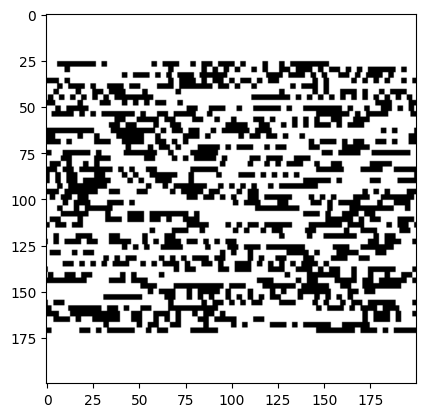

In [ ]:
from google.colab.patches import cv2_imshow

import cv2
from matplotlib import pyplot as plt

def mostrame(filename):
  # Load the PGM file
  img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

  # Display the image
  plt.imshow(img, cmap='gray')
  plt.show()

mostrame(imagen)

parece un codigo QR distorsionado, por lo cual no lo llevara a ningún lado... Para desencriptarlo corremos asi nuestro desencriptador

## Desencriptación

Lo compilamos así

In [ ]:
!nvcc desencriptador.cu -I. -o des.out

y lo corremos asi

In [ ]:
!./des.out {imagen}

desencriptando qr1.pgm_encripted.pgm


luego de correr se genera el archivo desencriptado, que tiene otro nombre. 

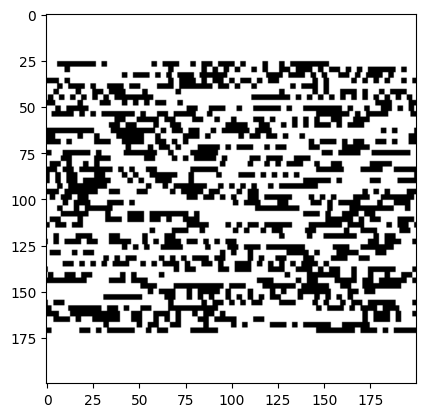

In [ ]:
imagen_desencriptada=imagen+"_desencripted.pgm"
mostrame(imagen_desencriptada)


Escanear el codigo QR. Si hizo bien las cosas, lo enviará a la respuesta del ejercicio. El template sin completar da como salida la imagen encriptada.

# ¿Solución?
